What is **Torch Vision**? 

`torchvision` is a library in PyTorch that has `datasets loaders`, `model architectures`, and `image transformation` tools specifically designed for computer vision. Here are its key capabilities:

1. **Datasets**: It provides easy-to-use APIs for a variety of vision datasets like ImageNet, CIFAR10, MNIST, etc. These can be used directly for model training and validation.

2. **Models**: torchvision offers pre-trained models for tasks like image classification, object detection, segmentation, etc. It includes models like ResNet, AlexNet, VGG, and Faster-RCNN.

3. **Transforms**: The library provides common image transformations like cropping, rotating, and flipping for data augmentation. It also includes transformations for tensor conversion and normalization.

4. **Utilities**: torchvision includes functions for drawing bounding boxes and masks onto images which can be helpful when working with object detection and segmentation tasks.

5. **IO operations**: From version 0.9.0 onward, torchvision includes functionalities to read video files and webcam stream into tensors, and also read and write image files.


https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/guide3/Debugging_PyTorch.html

## Setup
* Setting up Cuda, Tensorboad and SSL

In [7]:
import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [8]:
import torch
from torch.utils.tensorboard import SummaryWriter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
writer = SummaryWriter('runs/experiment_1')
log_dir = f"{os.getcwd()}/runs"

2023-05-21 18:00:44.404044: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
%%bash
if lsof -Pi :6006 -sTCP:LISTEN -t >/dev/null ; then
    echo "TensorBoard is already running"
else
    tensorboard --logdir=runs --port=6006 &
    echo "TensorBoard has started"
fi


TensorBoard has started



NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.12.3 at http://localhost:6006/ (Press CTRL+C to quit)


## Data Prep
### Load CIFAR-100

Pytorch's [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) API combines a `torchvision.datasets` and a `sampler`, and **provides an iterable** over the given dataset.

A valid counter part of this in the `tensorflow` world would be the https://www.tensorflow.org/api_docs/python/tf/data/Dataset  API that provides iterators, maps, sharding, loading and much much more

In [13]:
# Import necessary libraries
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

# Define transform to normalize the data
transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ]
)

# Download and load training dataset
trainset = torchvision.datasets.CIFAR10(root='data/', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True, num_workers=2)

Files already downloaded and verified


In [14]:
print(f"size of trainset = {len(trainset)}")
print(f"size of trainloader = {len(trainloader)}")


size of trainset = 50000
size of trainloader = 10000


In [17]:
testset = torchvision.datasets.CIFAR10(root='data/', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=2, shuffle=True, num_workers=2)
print(f"size of testset = {len(testset)}")
print(f"size of testloader = {len(testloader)}")

Files already downloaded and verified
size of testset = 10000
size of testloader = 5000


### Plot the data samples
Below we can see that we have loaded 10 images each of size `C:3, H:32, W:32` and their correponding sparse labels 

In [18]:
first_train_batch = next(iter(trainloader))
train_x = first_train_batch[0]
train_y  = first_train_batch[1]
print(f'train X shape: {train_x.shape} train Y: {train_y}')
                         

train X shape: torch.Size([5, 3, 32, 32]) train Y: tensor([4, 7, 8, 2, 2])


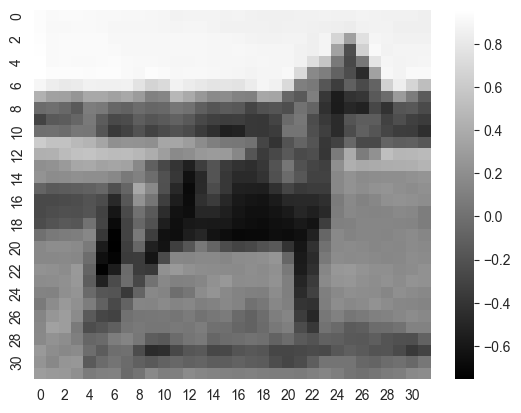

In [34]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# Let's grayscale the image by average across the channel dimension
image_tensor = train_x[1].mean(axis=0) 
# Squeeze the channel dimension
image_2d = image_tensor.squeeze(0)

# Plot using seaborn
sns.heatmap(image_2d, cmap='gray')
plt.show()


## Convnet Architecture 

<img src="conv2dShape.png" width="400" height="400">

In [35]:
# Define relevant variables for the ML task
batch_size = 64
num_classes = 10
learning_rate = 0.001
EPOCHS = 50

In [44]:
import torch.nn as nn
from torchsummary import summary

class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        self.relu = nn.ReLU()
        
        # block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=3)
        self.batch_norm1 = nn.BatchNorm2d(num_features=6)
        
        # block 2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.batch_norm2 = nn.BatchNorm2d(num_features=16)
        
        # Dense layers
        self.dense1 = nn.Linear(in_features=256, out_features=128)
        self.dense2 = nn.Linear(in_features=128, out_features=64)
        self.dense3 = nn.Linear(in_features=64, out_features=10)
        
        
    def forward(self, data, training=False):
        input_x, input_y = data
        
        x = self.pool1(self.relu(self.batch_norm1(self.conv1(input_x))))
        x = self.pool2(self.relu(self.batch_norm2(self.conv2(x))))
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.dense1(x))
        x = self.relu(self.dense2(x))
        x = self.relu(self.dense3(x))
        
        return x
    
    
convnet = ConvNet(num_classes=10)
print(summary(convnet, input_size=(10, 3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 34, 34]             168
       BatchNorm2d-2            [-1, 6, 34, 34]              12
              ReLU-3            [-1, 6, 34, 34]               0
         MaxPool2d-4            [-1, 6, 11, 11]               0
            Conv2d-5             [-1, 16, 9, 9]             880
       BatchNorm2d-6             [-1, 16, 9, 9]              32
              ReLU-7             [-1, 16, 9, 9]               0
         MaxPool2d-8             [-1, 16, 4, 4]               0
            Linear-9                  [-1, 128]          32,896
             ReLU-10                  [-1, 128]               0
           Linear-11                   [-1, 64]           8,256
             ReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 10]             650
             ReLU-14                   

In [45]:
logits = convnet(first_train_batch)

### Loss and Optimizer
* The `CrossEntpropyLoss` in Pytorch expects un-normalized probs. Unfortunately it has no option like **Tensorflow** to set `from_logits=True / False`. Therefore make sure you **don't use** `nn.Softmax`
* Additionally, there are more details about how to pass the the targets:
    * **As indices**: This is generally preferred for optimized computation. Eg `Target = 8 (horse class)`
    * **As probabiblities**: in case you want to use label smoothing. Eg: `Target = [0.2, 0.03, ...]`

In [46]:
loss_func = nn.CrossEntropyLoss(
    weight=None, 
    size_average=None,
    ignore_index=- 100,
    reduce=None, 
    reduction='mean',
    label_smoothing=0.0
)
optimizer = torch.optim.Adam(
    params=convnet.parameters(),
    lr=0.001, 
    betas=(0.9, 0.999), 
    eps=1e-08, 
    weight_decay=0, 
    amsgrad=False,
    foreach=None, 
    maximize=False, 
    capturable=False, 
    differentiable=False, 
    fused=None
)

### Training Loop

In [49]:
GRAD_ACC_ITER = 4

for epoch in range(20):
    running_loss = 0.0
    correct_predictions = 0
    
    # run over mini-batches of size 10
    for idx, (train_x, train_y) in enumerate(trainloader):
        train_x = train_x.to(device)
        train_y = train_y.to(device) 
        outputs = convnet(data=(train_x, train_y), training=True)
        
        _ , predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == train_y).sum().item()
        
        loss = loss_func(outputs, train_y)
        loss.backward()
        
        # gradient accumulation to speed up the training with small mini-batchces. 
        if ((idx + 1) % GRAD_ACC_ITER == 0) or (idx + 1 == len(trainloader)):
            optimizer.step()
            optimizer.zero_grad()
        
        running_loss += loss.item()
    
    accuracy = 100 * correct_predictions / len(trainset)
    
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch+1, EPOCHS, loss.item(), accuracy))
    
    writer.add_scalar('Loss/train', running_loss/idx+1, epoch)
    writer.add_scalar('Accuracy/train', accuracy, epoch)


Epoch [1/5], Loss: 1.5191, Accuracy: 46.18%
Epoch [2/5], Loss: 2.0409, Accuracy: 46.74%
Epoch [3/5], Loss: 1.5094, Accuracy: 47.32%
Epoch [4/5], Loss: 2.1736, Accuracy: 47.58%
Epoch [5/5], Loss: 1.4555, Accuracy: 47.96%
Epoch [6/5], Loss: 0.9975, Accuracy: 48.35%
Epoch [7/5], Loss: 1.1479, Accuracy: 48.51%
Epoch [8/5], Loss: 1.8623, Accuracy: 48.69%
Epoch [9/5], Loss: 0.8955, Accuracy: 48.94%
Epoch [10/5], Loss: 1.7871, Accuracy: 49.14%
Epoch [11/5], Loss: 1.5102, Accuracy: 49.43%
Epoch [12/5], Loss: 1.5297, Accuracy: 49.49%
Epoch [13/5], Loss: 1.6075, Accuracy: 49.79%
Epoch [14/5], Loss: 0.9241, Accuracy: 49.97%
Epoch [15/5], Loss: 0.6044, Accuracy: 50.05%
Epoch [16/5], Loss: 2.0353, Accuracy: 50.08%
Epoch [17/5], Loss: 1.3133, Accuracy: 50.41%
Epoch [18/5], Loss: 0.7230, Accuracy: 50.69%
Epoch [19/5], Loss: 0.9286, Accuracy: 50.56%
Epoch [20/5], Loss: 0.5836, Accuracy: 50.72%


In [185]:
for tag, value in convnet.named_parameters():

    if value.grad is not None:
        print(value.grad)
#         writer.add_histogram(tag + "/grad", value.grad.cpu(), step)

conv1.weight None
conv1.bias None
conv2.weight None
conv2.bias None
dense1.weight None
dense1.bias None
dense2.weight None
dense2.bias None
dense3.weight None
dense3.bias None


## Follow Up Deep Dives
* Deep Dive into Pytorch's [Autograd](https://pytorch.org/docs/stable/autograd.html)

<span style='background : yellow' > Background color is yellow 

```python
model = ... # your model
optimizer = tf.keras.optimizers.SGD() # your optimizer
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy() # your loss function
dataset = ... # your dataset
accumulation_steps = 4

@tf.function
def train_step(inputs, labels, model, optimizer, loss_fn, grad_list):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    
    # Accumulate gradients
    if grad_list is None:
        grad_list = gradients
    else:
        for i in range(len(gradients)):
            grad_list[i] += gradients[i]
    
    return loss, grad_list

for epoch in range(NUM_EPOCHS):
    grad_list = None
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(dataset):
        loss, grad_list = train_step(inputs, labels, model, optimizer, loss_fn, grad_list)

        # Only apply gradients and update model parameters every accumulation_steps
        if (i+1) % accumulation_steps == 0:
            optimizer.apply_gradients(zip(grad_list, model.trainable_variables))
            grad_list = None

    print(f"Epoch: {epoch}, Loss: {running_loss/len(dataset)}")
```
</span>

```python
model = ... # your model
optimizer = ... # your optimizer
criterion = ... # your loss function
dataloader = ... # your dataloader
accumulation_steps = 4

model.train()
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(dataloader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Instead of calling loss.backward(), we call loss.backward() / accumulation_steps
        loss.backward() 

        # Only update model parameters every accumulation_steps
        if (i+1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(f"Epoch: {epoch}, Loss: {running_loss/len(dataloader)}")
```

### Batch Normalization Deep Dive

* When BatchNorm is applied in CNNs, it is applied separately to each of the channels (C). This means the normalization is done on the `(N, H, W)` slices across each channel. For example, if we have a 3-channel RGB image, the normalization is done separately for the Red, Green, and Blue channels.

* That's why it's often referred to as "Spatial Batch Normalization". It's because the normalization is applied over the spatial dimensions (H, W) of the image, for each feature channel separately.

* As an example, suppose you have a mini-batch of `100 color images`, each of `32x32` pixels `(so, N=100, C=3, H=W=32)`. You compute the mean and variance for normalization over the `100x32x32` values in each color channel independently. These normalized values then get scaled and shifted using parameters that the network learns.

In [1]:
import numpy as np

# Assume input images is a 4D array with shape (N, C, H, W)
# Initialize with random values
N, C, H, W = 100, 3, 32, 32
images = np.random.randn(N, C, H, W)

def spatial_batchnorm(images):
    N, C, H, W = images.shape

    # Step 1: Reshape the images in (N*H*W, C) from (N, C, H, W)
    # We want to normalize over the mini-batch for each channel
    temp = images.transpose(1, 0, 2, 3).reshape(C, -1)

    # Step 2: Compute mean and variance along axis 0
    mu = temp.mean(axis=1)
    var = temp.var(axis=1)

    # Step 3: Normalize
    temp_normalized = (temp - mu[:, None]) / np.sqrt(var[:, None] + 1e-7)

    # Step 4: Reshape it back to original shape
    images_normalized = temp_normalized.reshape(C, N, H, W).transpose(1, 0, 2, 3)

    # Step 5: Scale and shift (if required, not done here)
    # For real use cases, we learn the scale (gamma) and shift (beta) parameters during training
    # images_normalized = gamma * images_normalized + beta

    return images_normalized


/Users/sarora/opt/anaconda3/envs/cyml38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sarora/opt/anaconda3/envs/cyml38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


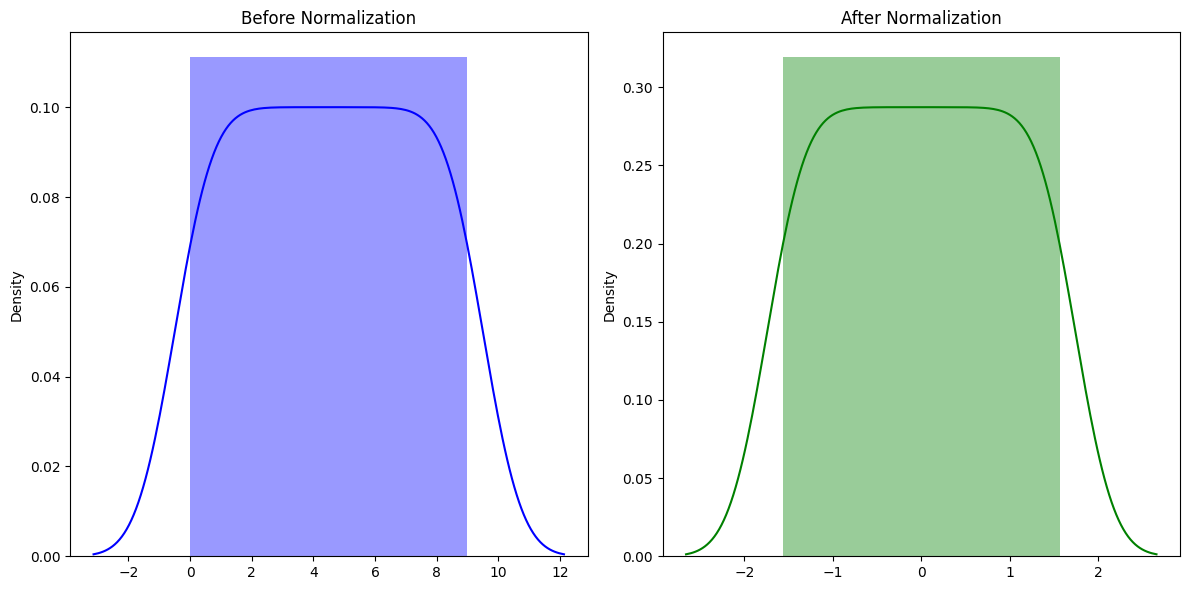

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

images = np.array([np.full((1, 4, 4), i) for i in range(10)])

normalized_images = spatial_batchnorm(images)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.distplot(images.flatten(), ax=axes[0], color='blue')
axes[0].set_title('Before Normalization')

sns.distplot(normalized_images.flatten(), ax=axes[1], color='green')
axes[1].set_title('After Normalization')

plt.tight_layout()
plt.show()
